In [1]:
import yelp_dataloader
import numpy as np
import os
from timeit import default_timer as timer
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import PIL
import torchvision.transforms as T

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def preprocess(img, size):
    t = T.Compose([
        T.Resize(size),
        T.RandomCrop(size),
        T.ToTensor()
    ])
    return t(img)

In [3]:
def show_images(images, x, y, f):
    fig = plt.figure(figsize=(18,10))
    gs = gridspec.GridSpec(x, y)
    gs.update(wspace=0.05, hspace=0.05)
    for i, img in enumerate(images):
        img = img.transpose(1,2,0)
        col = i // x
        row = i % x
        ax = plt.subplot(gs[row, col])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img)
        plt.savefig(f)
    return 

In [4]:
dir_path = '/home/Afshin/cs231n/cs231n-project/yelp-data-feats'
file_name_prefix='yelp_vgg16_fc7_'
num_batches=5
num_feats=4096
start = timer()
meta_feats, photo_feats = yelp_dataloader.read_yelp_photo_feats(dir_path, file_name_prefix, num_batches, num_feats)
end = timer()
print('load time for Yelp features.', (end - start))
print(meta_feats.shape)
print(photo_feats.shape)

/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_0.h5
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_1.h5
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_2.h5
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_3.h5
/home/Afshin/cs231n/cs231n-project/yelp-data-feats/yelp_vgg16_fc7_4.h5
load time for Yelp features. 91.96994336699981
(234842, 11)
(234842, 4098)


In [5]:
biz_dir_path = '/home/Afshin/cs231n/cs231n-project/yelp-biz-feats'
biz_file_name ='yelp_biz_vgg16_fc7.h5'
biz_id_feats, biz_id_labels = yelp_dataloader.read_yelp_biz_feats(biz_dir_path, biz_file_name)
biz_feats = biz_id_feats[:, 1:]
biz_labels = biz_id_labels[:, 1:]
print('biz_feats, ', biz_feats.shape)
print('biz_labels, ', biz_labels.shape)

biz_feats,  (2000, 4096)
biz_labels,  (2000, 9)


In [6]:
Num_train = 1800
Num_dev = 100
Num_test = 100
X_train = biz_feats[:Num_train]
y_train = biz_labels[:Num_train]
X_dev = biz_feats[Num_train: Num_train + Num_dev]
y_dev = biz_labels[Num_train: Num_train + Num_dev]
X_test = biz_feats[Num_train + Num_dev: Num_train + Num_dev + Num_test]
y_test = biz_labels[Num_train + Num_dev: Num_train + Num_dev + Num_test]

In [15]:
from sklearn.neural_network import MLPClassifier

optimal_size = 120
mpl = MLPClassifier(hidden_layer_sizes=(optimal_size))
mpl.fit(X_train,y_train)

mpl_train_pred = mpl.predict(X_train)
mpl_dev_pred = mpl.predict(X_dev)
f1_train = metrics.f1_score(y_train, mpl_train_pred, average='macro') 
f1_dev = metrics.f1_score(y_dev, mpl_dev_pred, average='macro')  
print('mpl train f1 = %f for hidden size %d' % (f1_train, optimal_size))
print('mpl dev f1 = %f for hidden size %d' % (f1_dev, optimal_size))

mpl train f1 = 0.816975 for hidden size 120
mpl dev f1 = 0.823126 for hidden size 120


In [16]:
photo_proba = mpl.predict_proba(photo_feats[:,2:])
print(photo_proba.shape)

(234842, 9)


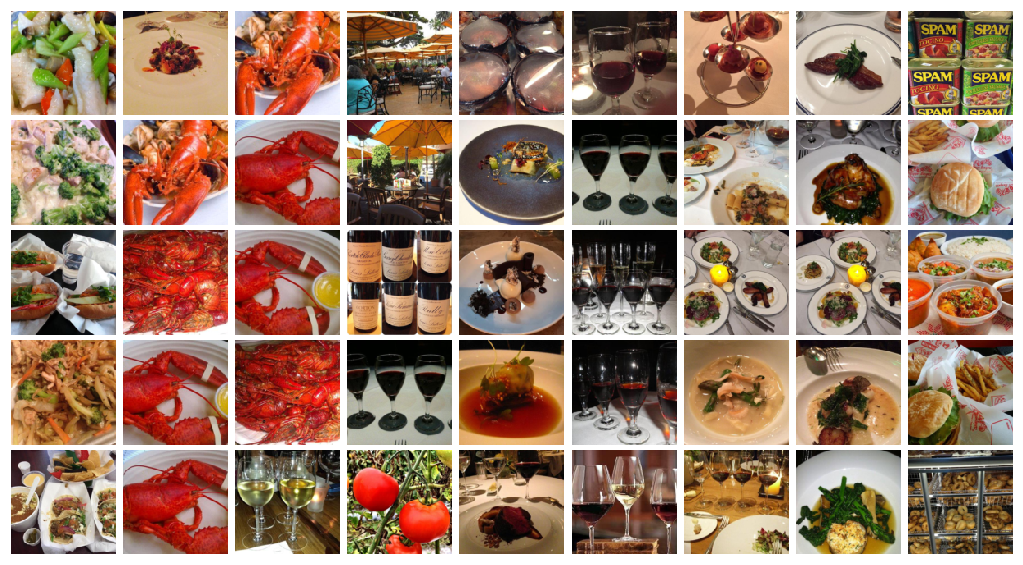

In [17]:
photo_dir = '/home/Afshin/cs231n/cs231n-project/yelp-data/train_photos'
img_size = 128
images = np.zeros((45, 3, img_size, img_size))
counter = 0
for label in range(9):
    indices = np.argpartition(photo_proba[:,label], -5)[-5:]
    for ind in indices:
        photo_id = int(photo_feats[ind][0])
        photo_path = os.path.join(photo_dir, str(photo_id) + '.jpg')
        image = PIL.Image.open(photo_path)
        image = preprocess(image, size=img_size).numpy()
        images[counter] = image
        counter += 1

file_path = os.path.join('/home/Afshin/cs231n/cs231n-project', 'class_photos.png')
show_images(images, 5, 9, file_path)

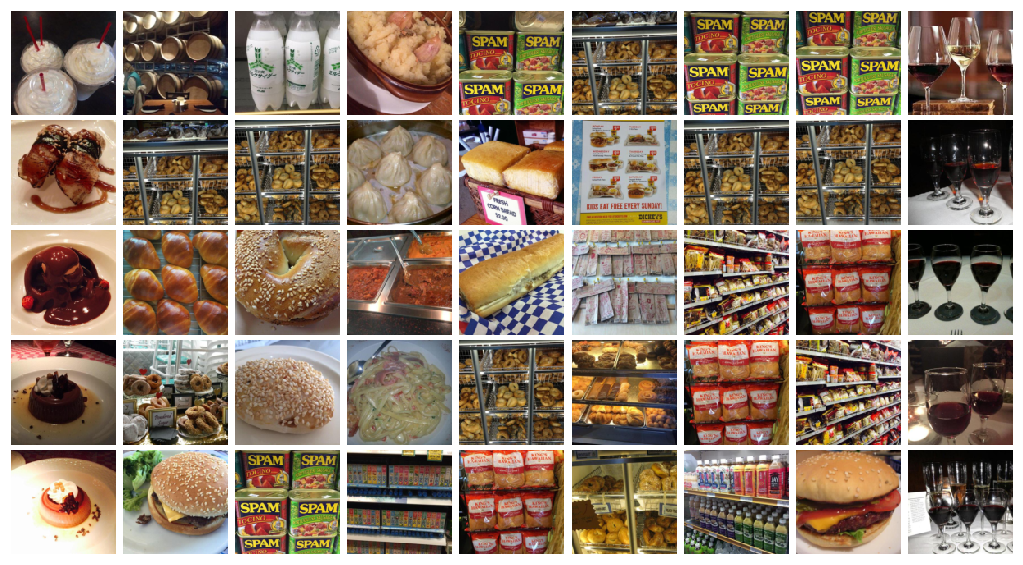

In [18]:
# Anti class photos
photo_dir = '/home/Afshin/cs231n/cs231n-project/yelp-data/train_photos'
img_size = 128
images = np.zeros((45, 3, img_size, img_size))
counter = 0
for label in range(9):
    indices = np.argpartition(photo_proba[:,label], 5)[:5]
    for ind in indices:
        photo_id = int(photo_feats[ind][0])
        photo_path = os.path.join(photo_dir, str(photo_id) + '.jpg')
        image = PIL.Image.open(photo_path)
        image = preprocess(image, size=img_size).numpy()
        images[counter] = image
        counter += 1

file_path = os.path.join('/home/Afshin/cs231n/cs231n-project', 'anti_class_photos.png')
show_images(images, 5, 9, file_path)